<a href="https://colab.research.google.com/github/Nungdoo/deep-learning-study/blob/main/exercise05_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 검증 세트 나누기

1. 테스트 세트로 모델을 튜닝하기
- 로지스틱 회귀로 모델 훈련하고 평가하기

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [2]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.8333333333333334

- 서포트 벡터 머신으로 모델 훈련하고 평가하기

In [3]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='hinge', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

2. 검증 세트를 분리하여 모델 튜닝하기

- 데이터 양이 적고 훈련 세트의 크기가 적어져 점수가 낮아짐

In [5]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(x_train), len(x_val))

sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

364 91


0.6923076923076923

# 전처리하기

1. 스케일 조정없이 모델 훈련

스케일 차이가 큰 특성을 가져옴

['mean perimeter' 'mean area']


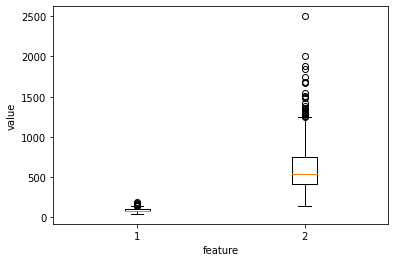

In [7]:
import matplotlib.pyplot as plt

print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

가중치의 변화를 관찰하기 위한 w_history와

가중치의 업데이트 양을 조절하기 위한 학습률 변수 learning_rate 추가
- 가중치를 너무 큰 폭으로 업데이트하는 경우, 손실 함수가 최소가 되는 지점(전역 최솟값)을 지나칠 수 있음
- 전역 최솟값을 놓치지 않도록 가중치의 업데이트 양을 조절해야 함

In [8]:
import numpy as np

class SingleLayer:

  def __init__(self, learning_rate=0.1):
    self.w = None
    self.b = None
    self.losses = []
    self.w_history = []
    self.lr = learning_rate

  def forpass(self, x):
    z = np.sum(x * self.w) + self.b   # 직선 방정식을 계산합니다.
    return z

  def backprop(self, x, err):
    w_grad = x * err  # 가중치에 대한 그레이디언트를 계산합니다.
    b_grad = 1 * err  # 절편에 대한 그레이디언트를 계산합니다.
    return w_grad, b_grad

  def activation(self, z):
    z = np.clip(z, -100, None)  # 안전한 np.exp() 계산을 위해
    a = 1 / (1 + np.exp(-z))    # 시그모이드 계산
    return a

  def fit(self, x, y, epochs=100):
    self.w = np.ones(x.shape[1])
    self.b = 0
    self.w_history.append(self.w.copy())                  # 가중치 기록
    np.random.seed(42)
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x)))  # 인덱스를 섞음
      for i in indexes:
        z = self.forpass(x[i])                            # 정방향 계산
        a = self.activation(z)                            # 활성화 함수 적용
        err = -(y[i] - a)                                 # 오차 계산
        w_grad, b_grad = self.backprop(x[i], err)         # 역방향 계산
        self.w -= self.lr * w_grad                        # 가중치 업데이트(학습률 적용)
        self.b -= b_grad

        self.w_history.append(self.w.copy())              # 가중치 기록
        
        # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적함
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
      # 에포크마다 평균 손실을 저장
      self.losses.append(loss/len(y))

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x]
    # a = self.activation(np.array(z))
    # return a > 0.5
    return np.array(z) > 0

  def score(self, x, y):
    return np.mean(self.predict(x) == y)


스케일 조정하지 않은 훈련 세트를 사용하기

In [9]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

0.9120879120879121

w[3](mean area)의 값이 큰 폭으로 흔들리며 변화함

모델이 불안정하게 수렴함

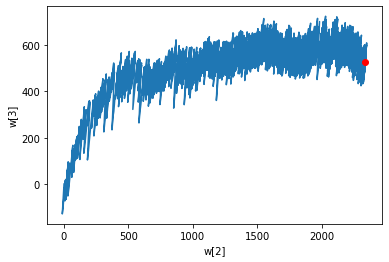

In [11]:
w2 = []
w3 = []
for w in layer1.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

2. 스케일 조정하여 모델 훈련

신경망에서 자주 사용하는 스케일 조정 방법 중 하나인 '표준화'

특성값에서 평균을 빼고 표준 편차로 나눔

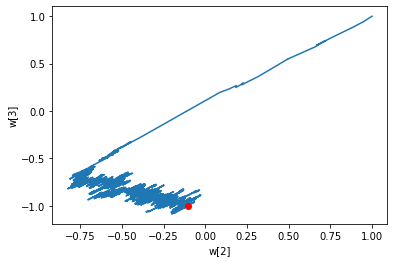

In [13]:
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std

layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)

w2 = []
w3 = []
for w in layer2.w_history:
  w2.append(w[2])
  w3.append(w[3])

plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

w2와 w3의 변화율이 비슷해 대각선 방향으로 가중치 이동

최적값에 빠르게 근접

In [14]:
layer2.score(x_val, y_val)

0.37362637362637363

검증 세트에도 표준화 전처리 적용

In [15]:
val_mean = np.mean(x_val, axis=0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - val_mean) / val_std
layer2.score(x_val_scaled, y_val)

0.967032967032967

훈련 세트와 검증 세트는 같은 비율로 스케일 조정이 되어야 함

올바르게 검증 세트 전처리하기
- 훈련 세트의 평균, 표준 편차를 이용해 검증 세트를 변환

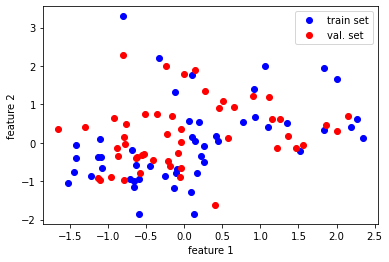

In [16]:
x_val_scaled = (x_val - train_mean) / train_std
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

In [17]:
layer2.score(x_val_scaled, y_val)

0.967032967032967